In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
#plt.rcParams['figure.dpi'] = 150

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [5]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### Building information footprint when the number of RNAPs/repressors exists on a distribution

In [6]:
def get_parameters(mean, cov):
	mu = np.log(mean) #- (np.log(cov**2 + 1) / 2)
	alpha = np.sqrt(np.log(cov**2 + 1)) / np.log(mean)
	sigma = alpha * np.log(mean)
	return mu, sigma


def simrep_pbound_with_noise(p_seq, r_seq, n_NS,
							 p_emat, r_emat, ep_wt, er_wt,
							 mean_p, mean_r, cov):
	rng = np.random.default_rng()
	
	mu_p, sigma_p = get_parameters(mean_p, cov)
	mu_r, sigma_r = get_parameters(mean_r, cov)

	n_p = rng.lognormal(mu_p, sigma_p, 1)[0]
	n_r = rng.lognormal(mu_r, sigma_r, 1)[0]
	
	w_p = tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
	w_r = tregs.simulate.get_weight(r_seq, r_emat, e_wt=er_wt)

	z = np.zeros(3)
	z[0] = 1
	z[1] = n_p / n_NS * w_p
	z[2] = n_r / n_NS * w_r

	return z[1] / np.sum(z)

In [7]:
def get_signal(footprint, region_param):
    signal = np.sum(footprint[(region_param[0]+115):(region_param[1]+116)])
    length = region_param[1] - region_param[0] + 1
    return signal, length

In [8]:
mutant_bank = []
for i in range(100):
    mutants = np.unique(tregs.wgregseq.mutations_rand(promoter,
                                                rate=0.1,
                                                num_mutants=5000,
                                                number_fixed=True,
                                                keep_wildtype=True))
    mutant_bank.append(mutants)

In [9]:
n_NS = len(genome)
ep_wt = -5
er_wt = -15
mean_p = 5000
mean_r = 100

l_cov = 10 ** np.arange(-1, 2.1, 0.1)
        
l_stn_ratio_rnap10 = []
l_stn_ratio_rnap35 = []
l_stn_ratio_lacI = []
for cov in l_cov:
    rnap10 = []
    rnap35 = []
    lacI = []
    for j in range(100):
        df = tregs.simulate.sim(promoter, simrep_pbound_with_noise, [rnap_site, rep_site], 
                                *[n_NS, rnap_emat, rep_emat, ep_wt, er_wt,
                                    mean_p, mean_r, cov],
                                preset_mutants=mutant_bank[i])
        
        nbins = 2
        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        upper_bound = np.mean(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                pseudocount=10**(-6))
        
        region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
        rnap35_signal, rnap35_length = get_signal(footprint, region_params[0])
        rnap10_signal, rnap10_length = get_signal(footprint, region_params[1])
        lacI_signal, lacI_length = get_signal(footprint, region_params[2])

        total_signal = rnap35_signal + rnap10_signal + lacI_signal
        total_noise = np.sum(footprint) - total_signal
        mean_noise = total_noise / (160 - (rnap35_length + rnap10_length + lacI_length))
        
        rnap10.append(rnap10_signal / rnap10_length / mean_noise)
        rnap35.append(rnap35_signal / rnap35_length / mean_noise)
        lacI.append(lacI_signal / lacI_length / mean_noise)
    l_stn_ratio_rnap10.append(np.mean(rnap10))
    l_stn_ratio_rnap35.append(np.mean(rnap35))
    l_stn_ratio_lacI.append(np.mean(lacI))

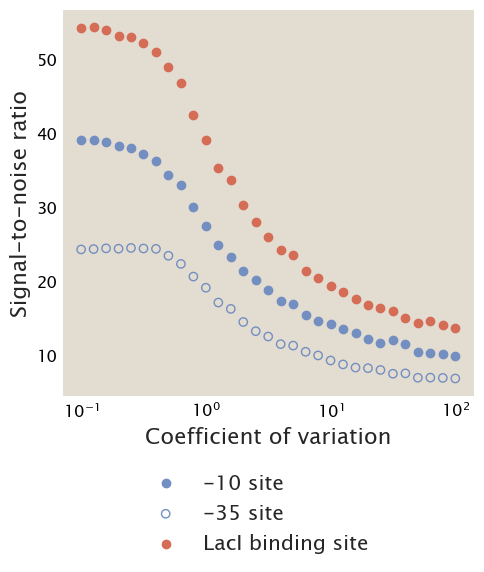

In [11]:
fig, ax = plt.subplots(figsize=(5, 6))
ax.scatter(l_cov, l_stn_ratio_rnap10, label='-10 site', color='#738FC1')
ax.scatter(l_cov, l_stn_ratio_rnap35, label='-35 site', facecolors='none', edgecolors='#738FC1', )
ax.scatter(l_cov, l_stn_ratio_lacI, label='LacI binding site',
           color='#D56C55')
ax.set_xlabel('Coefficient of variation', fontsize=16)
ax.set_ylabel('Signal-to-noise ratio',fontsize=16)
ax.legend(bbox_to_anchor=(0.79, -0.15), frameon=False, fontsize=15)
ax.set_xscale('log')

plt.tight_layout()
plt.savefig('../plots/fig12/extrinsic_noise.pdf')

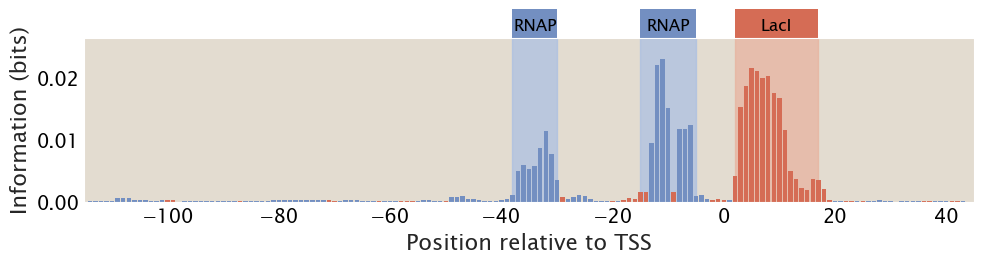

In [ ]:
n_NS = len(genome)
ep_wt = -5
er_wt = -15

mean_p = 5000
mean_r = 100
cov = 0.2

df = tregs.simulate.sim(promoter, simrep_pbound_with_noise, [rnap_site, rep_site], 
                        *[n_NS, rnap_emat, rep_emat, ep_wt, er_wt,
                          mean_p, mean_r, cov])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False,
                               outfile='../plots/fig12/extrinsic_noise_fp1.pdf')

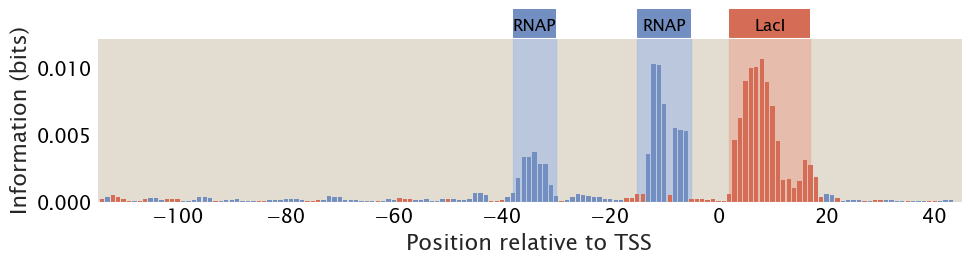

In [ ]:
n_NS = len(genome)
ep_wt = -5
er_wt = -15

mean_p = 5000
mean_r = 100
cov = 2

df = tregs.simulate.sim(promoter, simrep_pbound_with_noise, [rnap_site, rep_site], 
                        *[n_NS, rnap_emat, rep_emat, ep_wt, er_wt,
                          mean_p, mean_r, cov])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False,
                               outfile='../plots/fig12/extrinsic_noise_fp2.pdf')

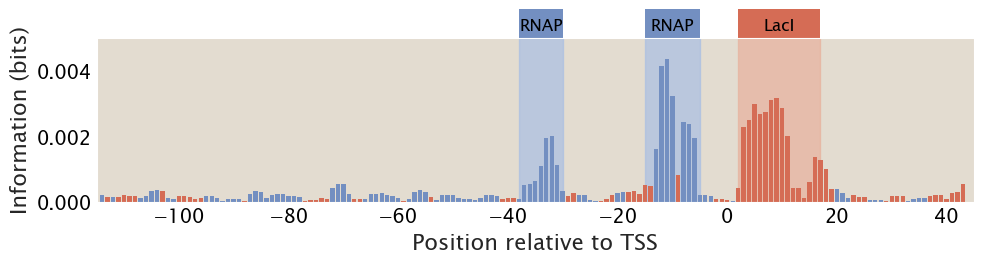

In [ ]:
n_NS = len(genome)
ep_wt = -5
er_wt = -15

mean_p = 5000
mean_r = 100
cov = 100

df = tregs.simulate.sim(promoter, simrep_pbound_with_noise, [rnap_site, rep_site], 
                        *[n_NS, rnap_emat, rep_emat, ep_wt, er_wt,
                          mean_p, mean_r, cov])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False,
                               outfile='../plots/fig12/extrinsic_noise_fp3.pdf')